# Price Predictor Supervised Model

In [82]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
from config import db_password

## Load in data

In [83]:
# database address
host_name = 'database-1.cvhixt1fojqo.us-east-1.rds.amazonaws.com'

In [84]:
# create the database engine
db_string = f"postgresql://postgres:{db_password}@{host_name}:5432/Crypto_Data"

In [85]:
engine = create_engine(db_string)

In [86]:
crypto_df = pd.read_sql("SELECT * FROM crypto_orig", con=engine)

In [87]:
crypto_df.shape

(5012, 9)

In [88]:
crypto_df.dtypes

type_crypto       object
date_orig         object
daystarttoend      int64
open_            float64
high_            float64
low_             float64
close_           float64
volume_          float64
marketcap_       float64
dtype: object

In [89]:
crypto_df.sample(10)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_
2577,eth,2020-03-29,910,130.990089,131.116210,124.808348,125.423225,7.682367e+09,1.417127e+10
1771,eth,2018-01-13,104,1352.236150,1570.126200,1349.752411,1456.138411,5.198393e+09,1.290000e+11
3429,xrp,2017-12-26,86,1.113651,1.191360,1.088362,1.177066,6.196316e+08,4.339728e+10
2655,eth,2020-06-15,988,232.624829,233.112739,219.776561,230.818125,8.069367e+09,2.531910e+10
3488,xrp,2018-02-23,145,0.936585,1.012223,0.898544,0.993751,8.208840e+08,3.773478e+10
515,ada,2019-03-01,516,0.043195,0.043775,0.042905,0.043164,2.174897e+07,1.121397e+09
1781,eth,2018-01-23,114,1011.513690,1031.321096,935.275830,986.845080,3.540462e+09,9.522773e+10
1703,eth,2017-11-06,36,292.421827,306.620296,290.437244,300.383551,3.348000e+08,2.883819e+10
401,ada,2018-11-07,402,0.080644,0.081043,0.077135,0.078432,4.332034e+07,2.059578e+09
4999,xrp,2022-04-14,1656,0.723332,0.740069,0.711206,0.725771,2.160489e+09,3.346555e+10


## Transform Datatypes

In [90]:
crypto_df['date_orig'] = pd.to_datetime(crypto_df["date_orig"])
crypto_df.dtypes

type_crypto              object
date_orig        datetime64[ns]
daystarttoend             int64
open_                   float64
high_                   float64
low_                    float64
close_                  float64
volume_                 float64
marketcap_              float64
dtype: object

## Split Data

In [91]:
crypto_list = crypto_df['type_crypto'].unique()
crypto_list

array(['ada', 'eth', 'xrp'], dtype=object)

## ML Model Functions

In [92]:
def pricepredict(df, dt):
    
    # number of future days to predict
    dt_days = dt
    
    # initialize dt column for how far we want to predict
    df['date_pred'] = df['date_orig'] + timedelta(days=dt_days)
    
    # create a copy dataframe to pull target close price
    df_copy = df.copy()
    
    # merge dataframes to get target variable
    df_clean = df.merge(df_copy, how='left', left_on='date_pred', right_on='date_orig', suffixes=(None, '_pred'))

    # drop empty rows
    df_pre_final = df_clean.dropna()
    
    # FOR POSTGRES "crypto_clean" table
    clean_df = df_pre_final[['type_crypto','date_orig','daystarttoend','open_','high_','low_','close_','volume_','marketcap_','date_pred','close__pred']]
    
    # only include relevant features (X) and target variables (y)
    df_final = df_pre_final[['open_','high_','low_','close_','volume_','marketcap_','close__pred']]
    
    # features
    X = df_final.drop('close__pred', axis=1)
    X = X.values.reshape(-1,6)
    
    # target
    y = df_final['close__pred']
    
    # initialize class for linear reg algorithms
    model = LinearRegression()
    
    # fit or train the data
    model.fit(X,y)
    
    # predict outcomes before current date
    y_pred = model.predict(X)
    
    # test data
    df_test = df_clean.loc[pd.isna(df_clean["type_crypto_pred"]),:]
    
    # test features
    X_test = df_test[['open_','high_','low_','close_','volume_','marketcap_']]
    X_test = X_test.values.reshape(-1,6)
    
    # test predictions
    y_pred_future = model.predict(X_test)
    
    # creating output dataframe
    close_pred_series = pd.Series(y_pred).append(pd.Series(y_pred_future))
    close_pred_df = pd.DataFrame(close_pred_series, columns=['close_'])
    close_pred_df.reset_index(inplace=True)
    predict_df = pd.DataFrame(df_clean['type_crypto'])
    predict_df['date_orig'] = df_clean['date_orig']
    predict_df['close_orig'] = df_clean['close_']
    predict_df['date_pred'] = df_clean['date_pred']
    predict_df['close_pred'] = close_pred_df['close_']
    
    # reconfiguring output dataframe
    predict_df_copy = predict_df.copy()
    predict_clean_df = predict_df.merge(predict_df_copy, how='left', left_on='date_pred', right_on='date_orig', suffixes=(None, '_copy'))
    predict_clean_df = predict_clean_df[['type_crypto','date_pred','close_orig_copy','close_pred']]
    predict_clean_df = predict_clean_df.rename(columns={'date_pred':'date','close_orig_copy':'close_orig'})
    
    return clean_df, predict_clean_df

In [93]:
#initial output tables
clean_df_60_day = pd.DataFrame()
predict_df_60_day = pd.DataFrame()
clean_df_30_day = pd.DataFrame()
predict_df_30_day = pd.DataFrame()

In [94]:
# for loop to separate models
for crypto in crypto_list:
    
    # run the ML models
    df = crypto_df.loc[crypto_df['type_crypto'] == crypto,:]
    clean_60_day, predict_60_day = pricepredict(df, 60)
    clean_30_day, predict_30_day = pricepredict(df, 30)
    
    #
    
    # create the output dataframes
    clean_df_60_day = clean_df_60_day.append(clean_60_day, ignore_index=True)
    predict_df_60_day = predict_df_60_day.append(predict_60_day, ignore_index=True)
    clean_df_30_day = clean_df_30_day.append(clean_30_day, ignore_index=True)
    predict_df_30_day = predict_df_30_day.append(predict_30_day, ignore_index=True)

/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [95]:
clean_df_60_day.sample(15)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred,close__pred
4777,xrp,2022-01-02,1554,0.849923,0.863112,0.839336,0.859375,1.091728e+09,3.915179e+10,2022-03-03,0.753014
4446,xrp,2021-02-05,1223,0.445612,0.467849,0.428476,0.450155,4.265099e+10,1.927818e+10,2021-04-06,1.110182
4248,xrp,2020-07-22,1025,0.199357,0.203686,0.196580,0.203498,1.068164e+09,8.613306e+09,2020-09-20,0.245987
4212,xrp,2020-06-16,989,0.192250,0.193561,0.190503,0.192191,7.523867e+08,8.302371e+09,2020-08-15,0.299222
1958,eth,2018-09-17,351,220.303037,224.394468,194.141729,197.065732,1.630899e+09,2.173700e+10,2018-11-16,176.323288
3461,xrp,2018-05-27,238,0.610972,0.668373,0.602866,0.606656,1.870662e+08,2.385176e+10,2018-07-26,0.449249
1412,ada,2021-08-14,1413,2.137423,2.245095,2.099254,2.191998,9.512367e+09,6.806403e+10,2021-10-13,2.185258
4337,xrp,2020-10-19,1114,0.242282,0.249377,0.240385,0.245859,1.081082e+09,1.060627e+10,2020-12-18,0.584029
3473,xrp,2018-06-08,250,0.677744,0.678939,0.663726,0.671915,1.730184e+08,2.633092e+10,2018-08-07,0.379847
3046,eth,2021-09-09,1439,3502.658400,3564.143316,3415.960000,3432.164300,3.724697e+10,4.110000e+11,2021-11-08,4819.161294


In [96]:
predict_df_60_day.tail(50)

,type_crypto,date,close_orig,close_pred
4962,xrp,2022-05-07,NaN,0.691071
4963,xrp,2022-05-08,NaN,0.707914
4964,xrp,2022-05-09,NaN,0.680575
4965,xrp,2022-05-10,NaN,0.693604
4966,xrp,2022-05-11,NaN,0.710849
4967,xrp,2022-05-12,NaN,0.710710
4968,xrp,2022-05-13,NaN,0.716072
4969,xrp,2022-05-14,NaN,0.711023
4970,xrp,2022-05-15,NaN,0.715262
4971,xrp,2022-05-16,NaN,0.723862


In [97]:
clean_df_30_day.sample(15)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred,close__pred
117,ada,2018-01-27,118,0.625648,0.644489,0.599477,0.622938,6.329197e+07,1.617362e+10,2018-02-26,0.326277
1418,ada,2021-08-20,1419,2.432215,2.574458,2.387025,2.458834,1.121266e+10,7.814217e+10,2021-09-19,2.287611
574,ada,2019-04-29,575,0.068823,0.069237,0.064537,0.064871,7.010161e+07,1.741187e+09,2019-05-29,0.091146
3168,eth,2021-12-10,1531,4129.372570,4219.469859,3918.337300,3918.337300,4.778168e+10,4.850000e+11,2022-01-09,3164.409305
88,ada,2017-12-29,89,0.412448,0.559057,0.402623,0.528676,1.491421e+08,1.184529e+10,2018-01-28,0.642901
2420,eth,2019-11-23,783,149.734062,153.396928,146.698521,151.752958,9.046499e+09,1.633077e+10,2019-12-23,128.028568
3894,xrp,2019-06-04,611,0.430768,0.430768,0.394511,0.402422,2.304599e+09,1.742611e+10,2019-07-04,0.389027
4248,xrp,2020-05-23,965,0.199893,0.201328,0.197983,0.198570,1.116026e+09,8.642228e+09,2020-06-22,0.189643
676,ada,2019-08-09,677,0.052142,0.052198,0.047415,0.047656,7.887375e+07,1.288745e+09,2019-09-08,0.046544
4094,xrp,2019-12-21,811,0.195269,0.195822,0.190910,0.191703,1.008425e+09,8.335485e+09,2020-01-20,0.233029


In [98]:
predict_df_30_day.tail(50)

,type_crypto,date,close_orig,close_pred
4962,xrp,2022-04-07,0.787914,0.697473
4963,xrp,2022-04-08,0.754096,0.748798
4964,xrp,2022-04-09,0.763062,0.698343
4965,xrp,2022-04-10,0.762818,0.762034
4966,xrp,2022-04-11,0.694468,0.703561
4967,xrp,2022-04-12,0.717054,0.719414
4968,xrp,2022-04-13,0.723957,0.745071
4969,xrp,2022-04-14,0.725771,0.745617
4970,xrp,2022-04-15,0.785042,0.755480
4971,xrp,2022-04-16,0.781577,0.745275


## High Level Visualization

In [99]:
ada_predict_df_30_day = predict_df_30_day.loc[predict_df_30_day['type_crypto'] == 'ada',:]

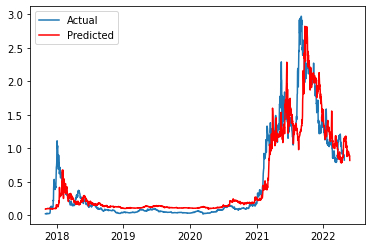

In [100]:
# TABLEAU VISUALIZATION
plt.plot(ada_predict_df_30_day.date, ada_predict_df_30_day.close_orig)
plt.plot(ada_predict_df_30_day.date, ada_predict_df_30_day.close_pred, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

In [ ]:
# TABLEAU VISUALIZATION
plt.plot(predict_df_30_day.date, predict_df_30_day.close_orig)
plt.plot(predict_df_30_day.date, predict_df_30_day.close_pred, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

## Send to Postgres

In [101]:
predict_df_60_day.to_sql(name='predict_df_60_day', con=engine)

In [102]:
predict_df_30_day.to_sql(name='predict_df_30_day', con=engine)

In [51]:
clean_df_60_day.to_sql(name='clean_df_60_day', con=engine)

In [52]:
clean_df_30_day.to_sql(name='clean_df_30_day', con=engine)